In [108]:
import os
import json
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations

from gensim.utils import simple_preprocess
from gensim.models import LdaModel

from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from nltk.corpus import stopwords
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def read_data(data_dir, start=1992, end=2018):
    articles = []
    
    for year in range(start, (end+1)):
        with open(os.path.join(data_dir, str(year) + '.json')) as f:
            articles += json.load(f)

    df = pd.DataFrame(articles)
    return df

In [3]:
df = read_data('data/stt_parsed', start=2007, end=2008)

In [4]:
df.head()

,date,subjects,title,body
0,2007-06-25T12:01:01,[Tiedotepalvelu],*** Tiedote/Finnair Oyj: Finnairin ensilento M...,\n ****STT-TIEDOTEPALVELU****\n\nFinnairin en...
1,2007-06-06T14:32:07,[Julkishallinnon tiedotepalvelu],*** Tiedote/Suomen Kuntaliitto: Kuntaliiton va...,\n ****STT-TIEDOTEPALVELU****\n\nJulkivapaa: ...
2,2007-05-09T17:46:51,[Politiikka],Vanhanen: EU puhui patsaskiistassa yhdellä suu...,\n Pääministeri Matti Vanhasen mielestä Viron...
3,2007-02-20T10:46:04,[None],Kala on superterveellistä,\n – Kala on hyvä proteiinin lähde. Sadassa g...
4,2007-11-21T11:39:09,[Kulttuuri],Led Zeppelin esittää Lontoossa uuden kappaleen,\n Led Zeppelin esittää joulukuun reunion-kei...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251056 entries, 0 to 251055
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      251056 non-null  object
 1   subjects  251056 non-null  object
 2   title     246961 non-null  object
 3   body      251056 non-null  object
dtypes: object(4)
memory usage: 7.7+ MB


In [6]:
df['date'] = pd.to_datetime(df['date']) # .dt.date

In [7]:
df.sort_values('date', inplace=True)

In [8]:
df.head()

,date,subjects,title,body
99695,2006-02-16 23:15:07,[Urheilu],Eto'o jälleen Afrikan paras jalkapalloilija,\n Kamerunilainen kärkipelaaja Samuel Eto'o o...
23091,2007-01-01 00:04:40,[Talous],Valko-Venäjä ja Gazprom sopivat kaasukiistansa,\n Valko-Venäjä ja venäläinen kaasujätti Gazp...
26047,2007-01-01 01:00:02,[Talous],Sloveniasta tuli kolmastoista euromaa,\n Slovenia on liittynyt euron käyttäjiin. Si...
24418,2007-01-01 01:21:26,[Kotimaa],Omakotitalo paloi Mäntsälässä,\n Hirsinen omakotitalo paloi Mäntsälässä myö...
29404,2007-01-01 02:15:08,[Ulkomaat],Chirac yhä vaitonainen jatkosuunnitelmistaan,\n Ranskan presidentti Jacques Chirac pitää e...


In [9]:
df.drop(99695, axis=0, inplace=True)

In [10]:
df = df[df['date'] < '2008-12-01']

In [12]:
df.tail()

,date,subjects,title,body
132073,2008-11-30 23:32:20,[Urheilu],Jalkapallotuloksia/Italia,"\n Italian Serie A: Palermo–Milan 3–1, Udines..."
205827,2008-11-30 23:33:40,[Peliuutiset],*** Veikkaus/Tulosveto ***,\n ****STT-TIEDOTEPALVELU**** Tulosveto 48/08...
248977,2008-11-30 23:34:42,[Ulkomaat],Avaruussukkula laskeutui Kaliforniaan,\n Avaruussukkula Endeavour laskeutui Kalifor...
234362,2008-11-30 23:49:50,[Urheilu],Alppihiihtotuloksia/mc,"\n Aspen, Colorado: Alppihiihdon maailmancup,..."
193070,2008-11-30 23:52:10,[Urheilu],Painituloksia/Kv. turnaus,\n Haaparanta: Kv. painin Haaparanta cup. Nai...


In [13]:
df['subjects'] = df['subjects'].apply(lambda x: x[0] if len(x) else "None")

In [14]:
df['title'].fillna('', inplace=True)

In [15]:
df['body'] = df['title'] + ' ' + df['body']

In [16]:
%%time
tokenized = df['body'].apply(simple_preprocess)

CPU times: user 1min 7s, sys: 812 ms, total: 1min 8s
Wall time: 1min 8s


In [17]:
doc_lengths = tokenized.apply(lambda x: len(x))

In [18]:
print("length of list:",len(doc_lengths),
      "\naverage document length", doc_lengths.mean(),
      "\nminimum document length", doc_lengths.min(),
      "\nmaximum document length", doc_lengths.max(),
      "\nnumber document less than {} words:".format(20), (doc_lengths < 20).sum(),
      "\nnumber document more than {} words:".format(2000), (doc_lengths > 2000).sum())

length of list: 241726 
average document length 154.6132935637871 
minimum document length 0 
maximum document length 7219 
number document less than 20 words: 8889 
number document more than 2000 words: 1895


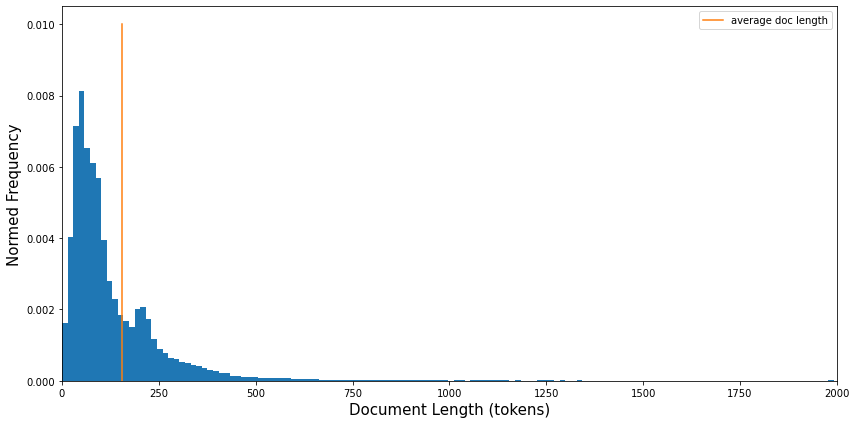

In [19]:
# plot a histogram of document length
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, bins=500, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()

plt.xlim(0, 2000)
# plt.ylim(0, 1)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0, 0.01, 10)], np.linspace(0.0, 0.01, 10), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [20]:
df['doc_len'] = doc_lengths
df['tokens'] = tokenized

In [21]:
# filter out documents < 20 or > 1000 tokens
df = df[(df['doc_len'] > 20) & (df['doc_len'] < 2000)]

In [22]:
df.shape

(229882, 6)

In [23]:
df.reset_index(drop=True, inplace=True)

In [24]:
df.head()

,date,subjects,title,body,doc_len,tokens
0,2007-01-01 00:04:40,Talous,Valko-Venäjä ja Gazprom sopivat kaasukiistansa,Valko-Venäjä ja Gazprom sopivat kaasukiistansa...,102,"[valko, venäjä, ja, gazprom, sopivat, kaasukii..."
1,2007-01-01 01:00:02,Talous,Sloveniasta tuli kolmastoista euromaa,Sloveniasta tuli kolmastoista euromaa \n Slov...,47,"[sloveniasta, tuli, kolmastoista, euromaa, slo..."
2,2007-01-01 01:21:26,Kotimaa,Omakotitalo paloi Mäntsälässä,Omakotitalo paloi Mäntsälässä \n Hirsinen oma...,32,"[omakotitalo, paloi, mäntsälässä, hirsinen, om..."
3,2007-01-01 02:15:08,Ulkomaat,Chirac yhä vaitonainen jatkosuunnitelmistaan,Chirac yhä vaitonainen jatkosuunnitelmistaan ...,86,"[chirac, yhä, vaitonainen, ranskan, presidentt..."
4,2007-01-01 02:17:19,Ulkomaat,Itävallan sisäministeri kuoli yllättäen,Itävallan sisäministeri kuoli yllättäen \n It...,44,"[itävallan, sisäministeri, kuoli, yllättäen, i..."


In [25]:
df.drop('title', inplace=True, axis=1)

In [26]:
df['subjects'].unique()

array(['Talous', 'Kotimaa', 'Ulkomaat', 'Politiikka', 'Urheilu', None,
       'Toimituksille tiedoksi', 'Sähkeuutiset', 'Päivälista',
       'Peliuutiset', 'Kulttuuri', 'Julkishallinnon tiedotepalvelu',
       'Tiedotepalvelu', 'Merkkipäiväpalvelu', 'Business wire'],
      dtype=object)

In [27]:
df.to_pickle('data/stt_token_cleaned.pkl')

In [34]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tokens'])]

In [35]:
model = Doc2Vec(vector_size=256, min_count=2, workers=4, dbow_words=1, negative=5)

In [36]:
%%time
model.build_vocab(documents)

CPU times: user 2min 3s, sys: 1 s, total: 2min 4s
Wall time: 2min 4s


In [37]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=30)

CPU times: user 1h 19min 48s, sys: 1min 44s, total: 1h 21min 32s
Wall time: 26min 26s


In [38]:
model.save('models/doc2vec/doc2vec_stt')

In [39]:
def infer_d2v(docs, model):
    vecs = np.zeros((len(docs), model.vector_size))
    for i, doc in enumerate(docs):
        vecs[i] = model.infer_vector(doc)
        
    return vecs

In [41]:
vecs = infer_d2v(df['tokens'], model)

In [42]:
pickle.dump(vecs, open('models/stt_vecs.pkl', 'wb'))

In [107]:
len(vecs)

229882

In [121]:
# train stt kmean
kmean = KMeans(n_clusters=30).fit(vecs)

In [124]:
def get_kmean_change(labels, df):
    changes = []    
    clusters = [list() for i in range(30)]
    
    # extract cluster ids
    for i, c in enumerate(labels):
        clusters[c].append(i)
    
    for c, ids in enumerate(clusters):
        # merge article index
        cluster = df.iloc[ids]
        counts = cluster.groupby(pd.Grouper(key='date', freq='7D')).size()
        # counts = cluster['date'].value_counts().sort_index()
        maj_class = cluster['subjects'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append((c, maj_class, counts))
        
    return changes, clusters

In [125]:
km_change, km_clusters = get_kmean_change(kmean.labels_, df)

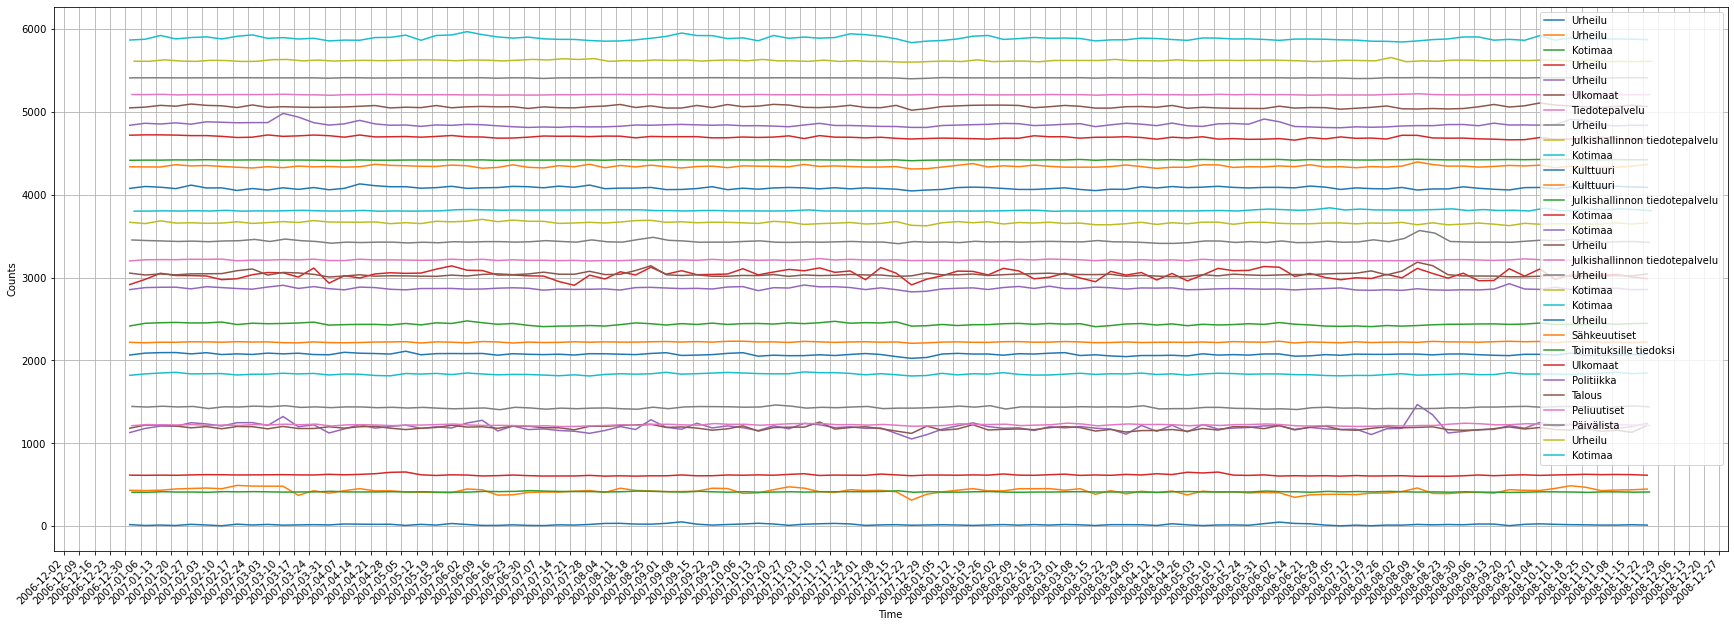

In [126]:
visualize_change(km_change)

In [127]:
pickle.dump(km_change, open('models/stt_km_changes2.pkl', 'wb'))

In [115]:
pickle.dump(kmean, open('models/stt_kmeans.pkl', 'wb'))

In [128]:
article_list = get_cluster_articles(km_clusters, df)

In [129]:
for i, a in enumerate(article_list):
    a = a.drop('tokens', axis=1)
    a.to_csv('models/stt_km_cluster_'+str(i)+'.csv', index=False)

In [28]:
# Do topic modeling
def load_model(name='lda_stt_2007_2008'):
    model = LdaModel.load('models/lda/' + name)
    dct = Dictionary.load('models/lda/'+ name + '.id2word')
    return model, dct

In [29]:
lda, dct = load_model()

In [30]:
stops_fi = set(stopwords.words('finnish'))
stops_fi2 = open("data/stopwords_fi_nlf.txt", "r").readlines()
stops_fi2 = [w.split()[1] for w in stops_fi2]
stops_fi.update(stops_fi2)
stops_fi = list(stops_fi)

In [31]:
def remove_stopwords(tokens, stopwords):
    # remove stopwords
    cleaned = [w for w in tokens if not w in stopwords]
    return cleaned

In [32]:
cleaned_docs = df['tokens'].apply(remove_stopwords, args=(stops_fi,))

In [ ]:
# cleaned_docs[0]

In [33]:
corpus = [dct.doc2bow(doc) for doc in cleaned_docs]

In [97]:

def get_clusters(lda, corpus, min_prob=0.1):
    clusters = [list() for i in range(20)]
    
    for i, doc in enumerate(corpus):
        topics = lda.get_document_topics(doc, minimum_probability=min_prob)
        
        # incase not belong to any topic > threshold
        if len(topics) == 0:
            topics = lda.get_document_topics(doc)
            topics = [topics[0]]

        topics = [t[0] for t in topics]
        
        for topic in topics:
            clusters[topic].append(i)
            
    return clusters

def get_topic_term(lda, dictionary, n=20):
    topics = []
    
    for i in range(20):
        terms = lda.get_topic_terms(i, topn=n)
        words = []
        for t in terms:
            words.append(dictionary[t[0]])
        topics.append(words)
        
    return topics

def get_cluster_change(clusters, df):
    changes = []
    
    for i, ids in enumerate(clusters):
        # merge article index
        cluster = df.iloc[ids]
        counts = cluster.groupby(pd.Grouper(key='date', freq='7D')).size()
        # counts = cluster['date'].value_counts().sort_index()
        maj_class = cluster['subjects'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append((i, maj_class, counts))
        
    return changes
    



In [44]:
clusters = get_clusters(lda, corpus, min_prob=0.15)

In [45]:
df['date'].min(), df['date'].max()

(Timestamp('2007-01-01 00:04:40'), Timestamp('2008-11-30 23:49:50'))

In [54]:
changes = get_cluster_change(clusters, df)

In [61]:
changes[0]

(0,
 'Talous',
 date
 2007-01-01    250
 2007-01-08    261
 2007-01-15    325
 2007-01-22    323
 2007-01-29    368
              ... 
 2008-10-27    345
 2008-11-03    307
 2008-11-10    313
 2008-11-17    304
 2008-11-24    292
 Freq: 7D, Length: 100, dtype: int64)

In [93]:
def visualize_change(changes):    
    fig, ax = plt.subplots(figsize=(30, 10))
    # index = np.arange(100)
    distance = 0
    
    # cluster, maj_cats, counts = zip(*changes)
    # counts = np.array(counts) + 1
    # print(counts.shape)
    # counts = counts / counts[:, 0][:,None]
    # print(counts[-1])
    
    
    for cluster, cat, counts in changes:
        # val = counts[i] + distance
        # index = counts.index
        val = counts.values + distance
        ax.plot(counts.index, val, label=cat)
        distance += 200
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.set(xlabel='Time', ylabel='Counts')
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
    ax.legend()
    ax.grid()

    plt.show()


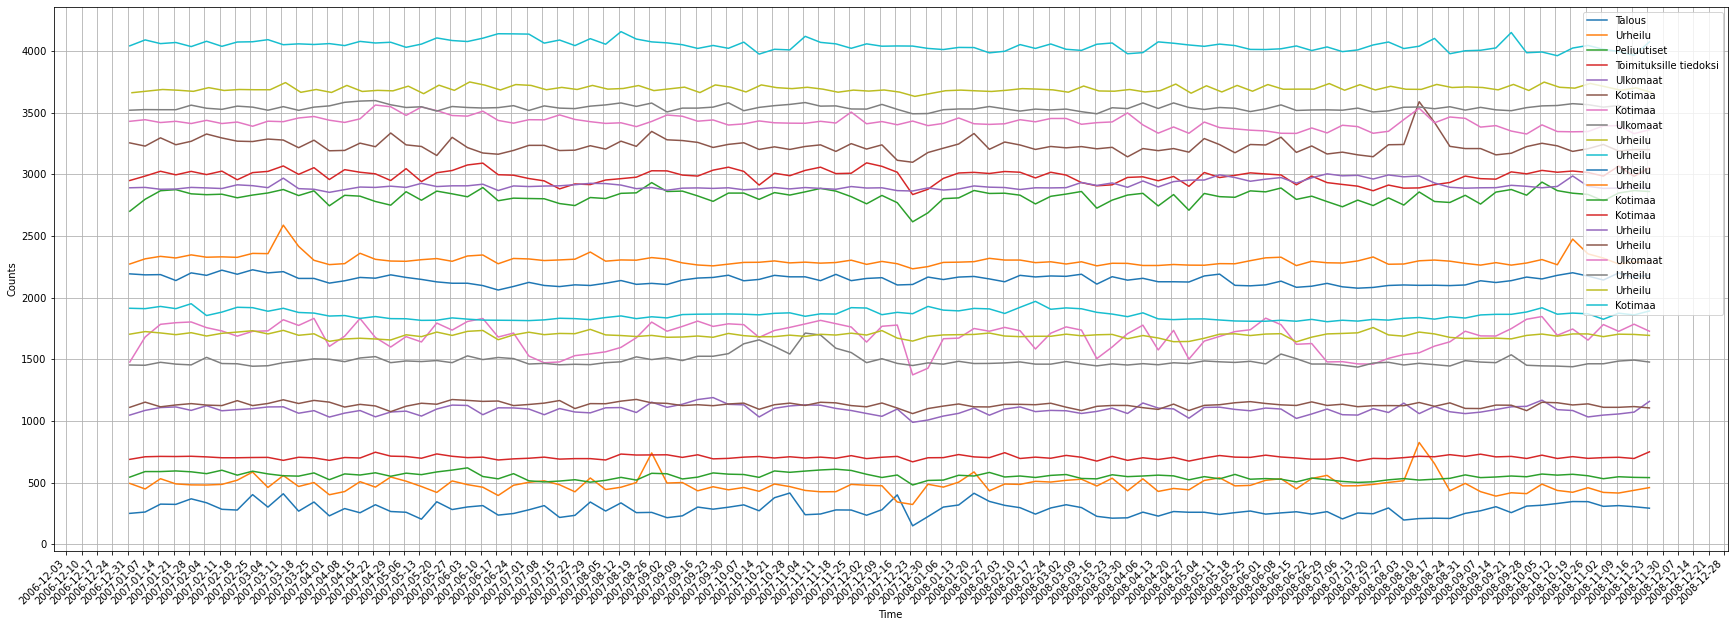

In [94]:
visualize_change(changes)

In [68]:
def get_cluster_articles(clusters, df):
    article_list = []
    for cluster in clusters:
        articles = df.iloc[cluster]
        article_list.append(articles)
        
    return article_list

In [69]:
article_list = get_cluster_articles(clusters, df)

In [71]:
article_list[3].head()

,date,subjects,body,doc_len,tokens
20,2007-01-01 06:00:10,None,Artikkelit viikko 1 \n \n ARTIKKELIT VIIKKO 1...,198,"[artikkelit, viikko, artikkelit, viikko, alla,..."
21,2007-01-01 06:00:10,Toimituksille tiedoksi,Artikkelit viikko 1 \n \n ARTIKKELIT VIIKKO 1...,198,"[artikkelit, viikko, artikkelit, viikko, alla,..."
57,2007-01-01 10:13:22,Toimituksille tiedoksi,Toimituksille tiedoksi \n \n Uudenvuodenpäivä...,150,"[toimituksille, tiedoksi, kotimaa, uudenvuoden..."
91,2007-01-01 15:05:23,Toimituksille tiedoksi,Ulkomaantoimituksille \n Iltaversio luvassa T...,92,"[iltaversio, luvassa, thaimaan, pommi, iskujen..."
101,2007-01-01 16:06:25,Toimituksille tiedoksi,Ulkomaantoimituksille -2 \n Indonesiassa kado...,39,"[indonesiassa, kadonneen, kohtalo, seurannassa..."


In [75]:
for i, a in enumerate(article_list):
    a = a.drop('tokens', axis=1)
    a.to_csv('models/stt_cluster_'+str(i)+'.csv', index=False)

In [73]:
pickle.dump(changes, open('models/stt_changes.pkl', 'wb'))

In [74]:
pickle.dump(clusters, open('models/stt_clusters.pkl', 'wb'))

In [98]:
terms = get_topic_term(lda, dct, n=30)

In [102]:
len(terms)

20

In [103]:
terms = pd.DataFrame(terms, columns=list(range(30)))
terms = terms.transpose()

In [104]:
terms.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,prosenttia,voitti,tiedote,mennessä,kertoi,helsingin,suomen,neuvottelut,antti,kosovon,kilpailu,keskustan,vain,suomen,kerroin,suomi,presidentti,kaudella,that,poliisi
1,euroa,kauden,tiedotepalvelu,ruotsin,keskiviikkona,mies,puheenjohtaja,tänään,jukka,metriä,miesten,puolueen,sanoo,vuonna,lähtö,venäjä,venäjän,liigan,finnish,ihmistä
2,vuonna,pistettä,http,merkkiä,torstaina,käräjäoikeus,hallituksen,sopimuksen,mikko,peliaika,ottelun,helsinki,hyvin,vuoden,toto,saksa,yhdysvaltain,joukkueen,finland,poliisin
3,miljoonaa,sarjan,liitteet,kuva,tiistaina,miehen,hallitus,alan,pekka,serbian,naisten,naiset,pitää,helsingin,poissa,ruotsi,pääministeri,valmentaja,said,mies
4,vuoden,suomen,lisätietoja,juttu,perjantaina,oikeus,uuden,putin,ville,jääkiekko,päivän,kokoomuksen,olevan,vuotta,oikea,ranska,venäjä,pelannut,minister,kuoli


In [105]:
terms.to_csv('models/stt_terms.csv', index=False)